# Fitting the RBC for Italy - Complex model

## Table of Content
* [Capital Adjustment cost Model](#chapter0)
    * [Model Equations](#section_0_1)
    * [Find Steady State, Solve the Model](#section_0_2)
    * [Check Blanchard Kahn Conditions](#section_0_3)
* [Maximum Likelihood Estimation](#chapter1)
    * [Final Model](#section_1_1)
        * [MLE Kalman Filter Prediction Plots](#subsection_1_1)
        * [Forecasting](#subsection_1_2)
        * [Impulse Response](subsection_1_3)
* [Bond Model](#chapter2)
    * [Model Equations](#section_2_1)
    * [Find Steady State, Solve the Model](#section_2_2)
    * [Check Blanchard Kahn Conditions](#section_2_3)
* [Maximum Likelihood Estimation](#chapter3)
    * [Final Model](#section_3_1)
        * [MLE Kalman Filter Prediction Plots](#subsection_3_1)
        * [Forecasting](#subsection_3_2)
        * [Impulse response](#subsection_3_3)

In [1]:
%run init_notebookspace.py
from settings import *

DATA_DIR is existant under: C:\Users\LukasGrahl\Documents\GIT\macro_rbc\data


In [2]:
%matplotlib inline
import gEcon as ge
import gEcon.plotting as gp
from gEconpy.shared.utilities import eq_to_ss
from gEconpy.classes.time_aware_symbol import TimeAwareSymbol
from gEcon.classes.transformers import PositiveTransformer, IntervalTransformer

import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary, plot_sm_results
from src.utils import get_max_seasonal, OLS_dummie_deseasonal

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)
calibrated_params = {'beta':0.9998, 'alpha':0.262, 'sigma_L':0.52,'sigma_C': 0.0068, 'delta':0.01, 'rho_A': 0.9405}
plot_vars = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']
maxiter = 15

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
def plot_sm_results(res, extra_data=None, filter_output='predicted', var_names=None):
    fig = plt.figure(figsize=(14,8))
    
    endog_vars = res.data.ynames
    states = res.states.predicted.columns
    if var_names:
        states = [x for x in states if x in var_names]
    
    gs, plot_locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=len(states))
    
    for i, (name, loc) in enumerate(zip(states, plot_locs)):
        axis = fig.add_subplot(gs[loc])

        mu = getattr(res.states, filter_output)[name]
        sigma = getattr(res.states, filter_output + '_cov').loc[name, name]

        upper = mu + 1.98 * np.sqrt(sigma + 1e-8)
        lower = mu - 1.98 * np.sqrt(sigma + 1e-8)

        start_idx = 1 if filter_output == 'predicted' else 0
        axis.plot(res.data.dates, mu.values[start_idx:], label='Predicted')
        axis.fill_between(res.data.dates, lower.values[start_idx:], upper.values[start_idx:], color='tab:blue', alpha=0.25)

        if name in endog_vars:
            res.data.orig_endog[name].plot(label='Data', ax=axis)
        
        elif extra_data is not None:
            if name in extra_data.columns:
                extra_data[name].plot(label='Data', ax=axis)

        axis.set(title=name)
    fig.tight_layout()
    title_text = 'One-Step Ahead' if filter_output =='predicted' else filter_output.title()
    fig.suptitle(f'Kalman {title_text} Predictions', y=1.05)
    fig.axes[1].legend(bbox_to_anchor=(0.5, 0.98), loc='lower center', bbox_transform=fig.transFigure, ncols=2)

    plt.show()
    pass

In [6]:
# load data
train = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))

# drop csv index
train.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)

# time format index
train['TIME'] = time_format(train.TIME)
test['TIME'] = time_format(test.TIME)

# set index - get's lost with csv
train.set_index('TIME', inplace=True)
test.set_index('TIME', inplace=True)

# asign correct time freq
train = train.asfreq('QS')
test = test.asfreq('QS')

glob_cols = list(train.columns)
test_size = len(test)

We are loading data and assign quaterly time frequency for pandas to feed to the Kalman-Filter estimation.

# Capital Adjustment cost Model <a class="anchor" id="chapter0"></a>

The 'rbc_capadj.gnc' includes captial adjustment cost as a squared cost term beyond anual depreciation. This term smoothes the investment response to a productivity shock across time, the visual result is a hump shaped investement response function, instead of a shark fin.
$$ K_t = I_t - \frac{\phi}{2} * (\frac{I_t}{K_{t-1}} - \delta) ^ 2 * K_{t-1} + (1 - \delta) * K_{t-1} $$

In [7]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_capadj.gnc'))

Model Building Complete.
Found:
	11 equations
	11 variables
	The following variables were eliminated at user request:
		TC_t,U_t
	The following "variables" were defined as constants and have been substituted away:
		mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	7 parameters
		 0 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_0_1"></a>

In [8]:
for equation in rbc.system_equations:
    display(equation)

-Q_t + lambda_t/q_t

-C_t - I_t + K_t-1*r_t + L_t*w_t

-1*phi*(-delta + I_t/K_t-1)**2*K_t-1/2 + I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

-lambda_t - q_t*(phi*(-delta + I_t/K_t-1) - 1)

beta*(lambda_t+1*r_t+1 - q_t+1*(delta - phi*I_t+1*(-delta + I_t+1/K_t)/K_t + phi*(-delta + I_t+1/K_t)**2/2 - 1)) - q_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_0_2"></a>

Steady state values according to the parameters literature suggests for Italy. These were specified in the GCN file.

In [9]:
rbc.steady_state()
rbc.solve_model()

Steady state found! Sum of squared residuals is 7.407896938091064e-30
Solution found, sum of squared residuals:  4.448401792317777e-31
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [10]:
rbc.print_steady_state()

A_ss               1.000
C_ss               1.235
I_ss               0.185
K_ss              18.508
L_ss               0.571
Q_ss               1.000
Y_ss               1.420
lambda_ss          0.407
q_ss               0.407
r_ss               0.020
w_ss               1.836


The results of the steady state are the same as with the basic RBC model, which is to be expected, as adjustement cost only affect the covergence towards the steady steady, not the state itself. 

## Check Blanchard Kahn Conditions <a class="anchor" id="section_0_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state. They stipulate that non-arbitrary stability requires as many Eigenvalues with modulus greate than 1 as forward looking varibles, this condition is satisfied in this case.

In [11]:
rbc.check_bk_condition()

Model solution has 4 eigenvalues greater than one in modulus and 4 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,9.870786e-20,9.870786e-20,0.0
1,3.285220e-18,3.285220e-18,0.0
2,6.711115e-18,6.711115e-18,0.0
3,1.695515e-17,1.695515e-17,0.0
4,9.405000e-01,9.405000e-01,0.0
5,9.708527e-01,9.708527e-01,0.0
6,1.040427e+00,1.040427e+00,0.0
7,3.922590e+06,3.922590e+06,0.0
8,5.278087e+07,5.278087e+07,0.0
9,6.197757e+07,6.197757e+07,0.0


In [14]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

# Maximum Likelihood Estimation <a class="anchor" id="chapter1"></a>

In [15]:
# assign date freq
train = train.asfreq("QS")
train.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,0.034739,0.025376,0.030090,0.073761,NaN,0.006896
1996-04-01,-0.023203,0.006568,0.023159,-0.032295,NaN,NaN
1996-07-01,-0.047401,-0.006060,0.019601,-0.077407,NaN,NaN
1996-10-01,-0.040238,-0.003936,0.010456,-0.046165,NaN,NaN
1997-01-01,-0.037205,-0.012070,0.009416,-0.052189,NaN,-0.005354


## Final model <a class="anchor" id="section_1_1"></a>

We estimate directly the same final model specificaiton as with the basic RBC to compare findings and model fit.

In [18]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [19]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.85,
                    'sigma_C':0.1,
                    'sigma_L':0.3,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.01,
                    'w':0.01,
                    'r':0.01,
                    'C':0.01,
                    'I':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=0.001, high=5.0),
                    'sigma_L':IntervalTransformer(low=0.001, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
mle_mod = MLEModel(train[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [20]:
# %%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f 317.37
basinhopping step 1: f 317.37 trial_f 352.873 accepted 0  lowest_f 317.37
basinhopping step 2: f 32.0023 trial_f 32.0023 accepted 1  lowest_f 32.0023
found new global minimum on step 2 with function value 32.0023
basinhopping step 3: f 10.0502 trial_f 10.0502 accepted 1  lowest_f 10.0502
found new global minimum on step 3 with function value 10.0502
basinhopping step 4: f 10.0502 trial_f 10.4672 accepted 0  lowest_f 10.0502
basinhopping step 5: f 10.0502 trial_f 11.8603 accepted 0  lowest_f 10.0502
basinhopping step 6: f 8.14903 trial_f 8.14903 accepted 1  lowest_f 8.14903
found new global minimum on step 6 with function value 8.14903
basinhopping step 7: f 7.4096 trial_f 7.4096 accepted 1  lowest_f 7.4096
found new global minimum on step 7 with function value 7.4096
basinhopping step 8: f 7.75058 trial_f 7.75058 accepted 1  lowest_f 7.4096
basinhopping step 9: f 8.221 trial_f 8.221 accepted 1  lowest_f 7.4096
basinhopping step 10: f 8.221 trial_f 8.36674 

In [22]:
mle_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'L', 'w', 'r', 'C', 'I']   No. Observations:                   80
Model:                                  DSGEModel   Log Likelihood                 -97.163
Date:                            Thu, 29 Dec 2022   AIC                            218.327
Time:                                    11:19:57   BIC                            246.911
Sample:                                01-01-1996   HQIC                           229.787
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.5358     30.968      0.017      0.986     -60.160      61.231
sigma_C              0.0087     82.564      0.000      1.000    -161.815     161.832
sigma_L              1.4084    228.787      0.006      0.995    -447.006     449.823
alpha                0.4406    712.045      0.001      1.000   -1395.141    1396.022
beta                 0.9862     84.566      0.012      0.991    -164.759     166.732
delta                0.0398      2.919      0.014      0.989      -5.681       5.760
sigma2.epsilon_A     1.1264    777.422      0.001      0.999   -1522.592    1524.845
sigma2.L             0.3698      0.207      1.785      0.074      -0.036       0.776
sigma2.w             0.0990      0.069      1.432      0.152      -0.037       0.234
sigma2.r             0.1314      1.960      0.067      0.947      -3.710       3.973
sigma2.C             0.0487      0.582      0.084      0.933      -1.093       1.190
sigma2.I             0.5734     55.885      0.010      0.992    -108.960     110.107
===============================================================================================================================
Ljung-Box (L1) (Q):     34.57, 0.00, 64.11, 61.26, 50.83, 54.77   Jarque-Bera (JB):   136.73, 395.37, 84.16, 56.96, 9.52, 53.88
Prob(Q):                     0.00, 1.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                  0.00, 0.00, 0.00, 0.00, 0.01, 0.00
Heteroskedasticity (H):       0.93, 0.69, inf, 1.92, 3.75, 2.04   Skew:                     -1.54, 1.38, 1.28, 1.38, 0.83, 1.39
Prob(H) (two-sided):         0.85, 0.34, 0.00, 0.10, 0.00, 0.07   Kurtosis:                 8.61, 13.54, 7.33, 6.08, 3.32, 5.90
===============================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_1_1"></a>

At first glance the he model does not fit the data well, confidence intervals are rather broad and thus plots are not very informative.

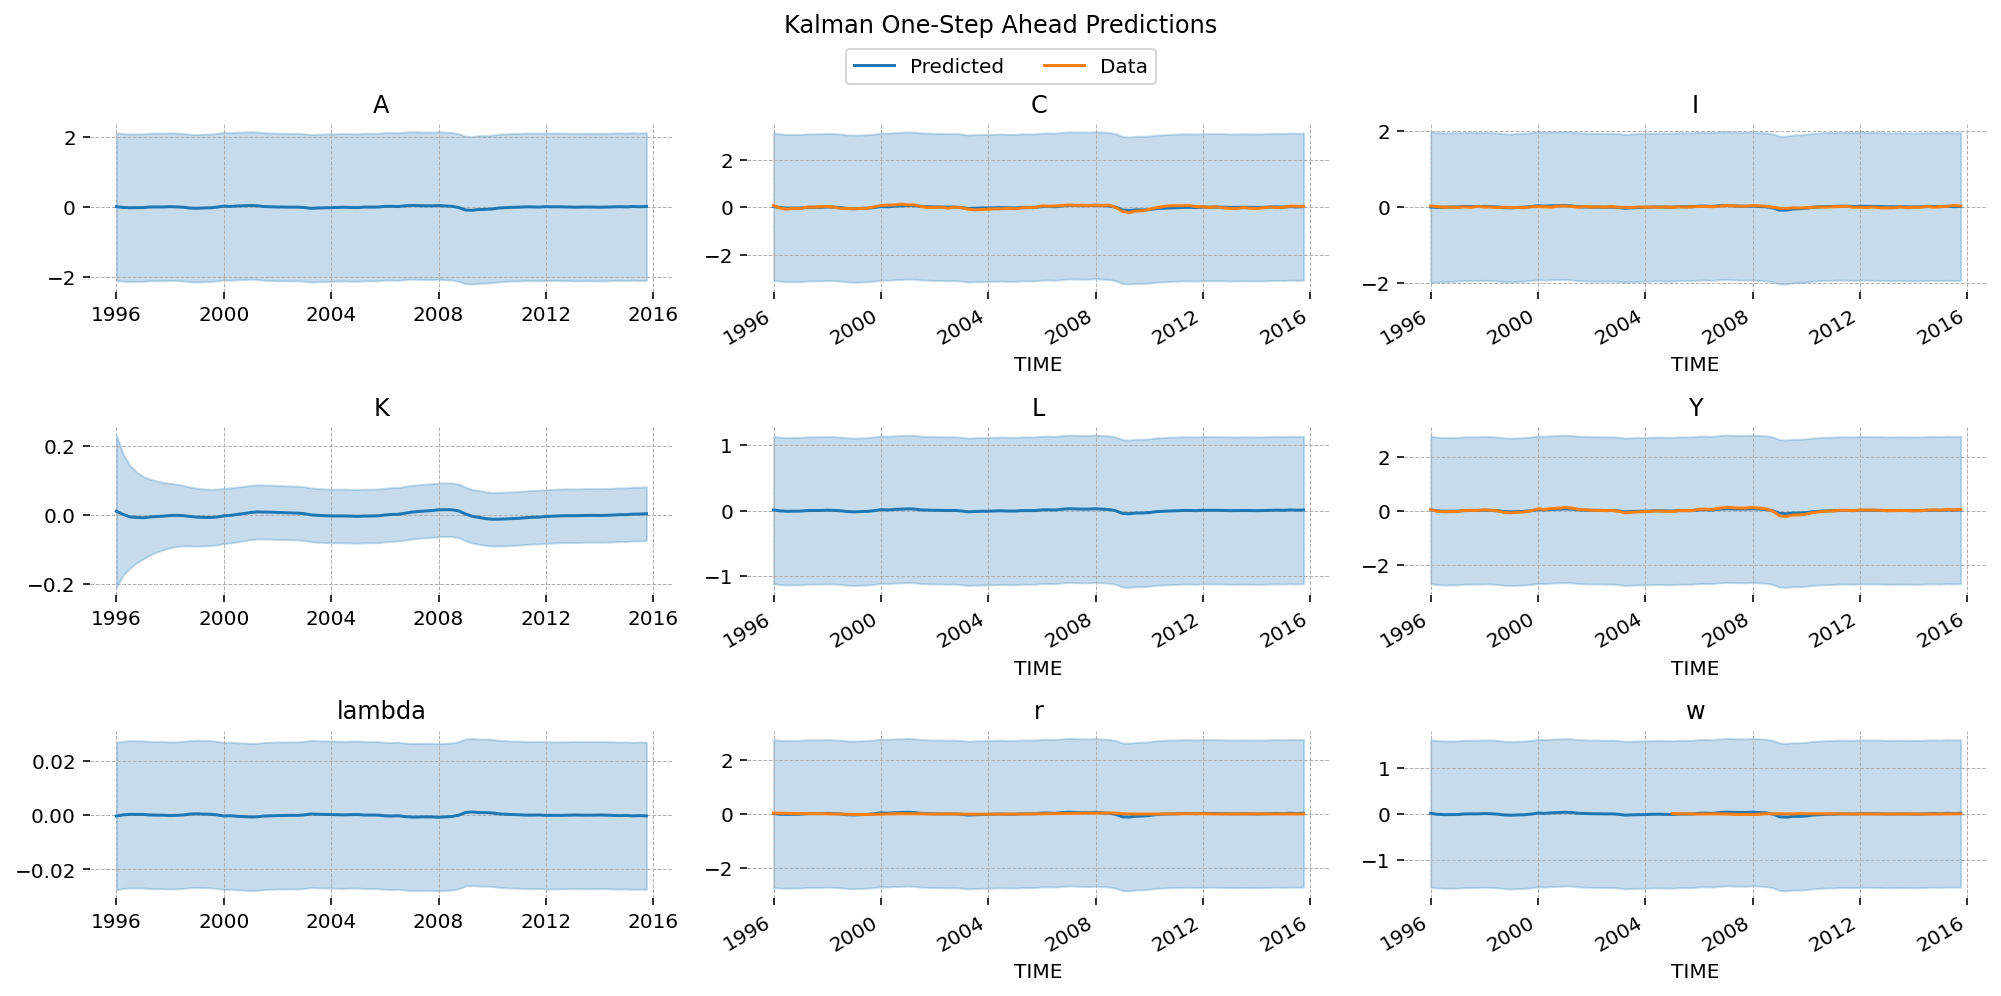

In [26]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

Considering the smoothed output we can however observe some meaningful results. While still out of confidence bounds the model fits the Investment response more closely than in the basic RBC. The same goes for consumption which traced even more closely with some slightly overaccentuated but directionally correct predictions. 

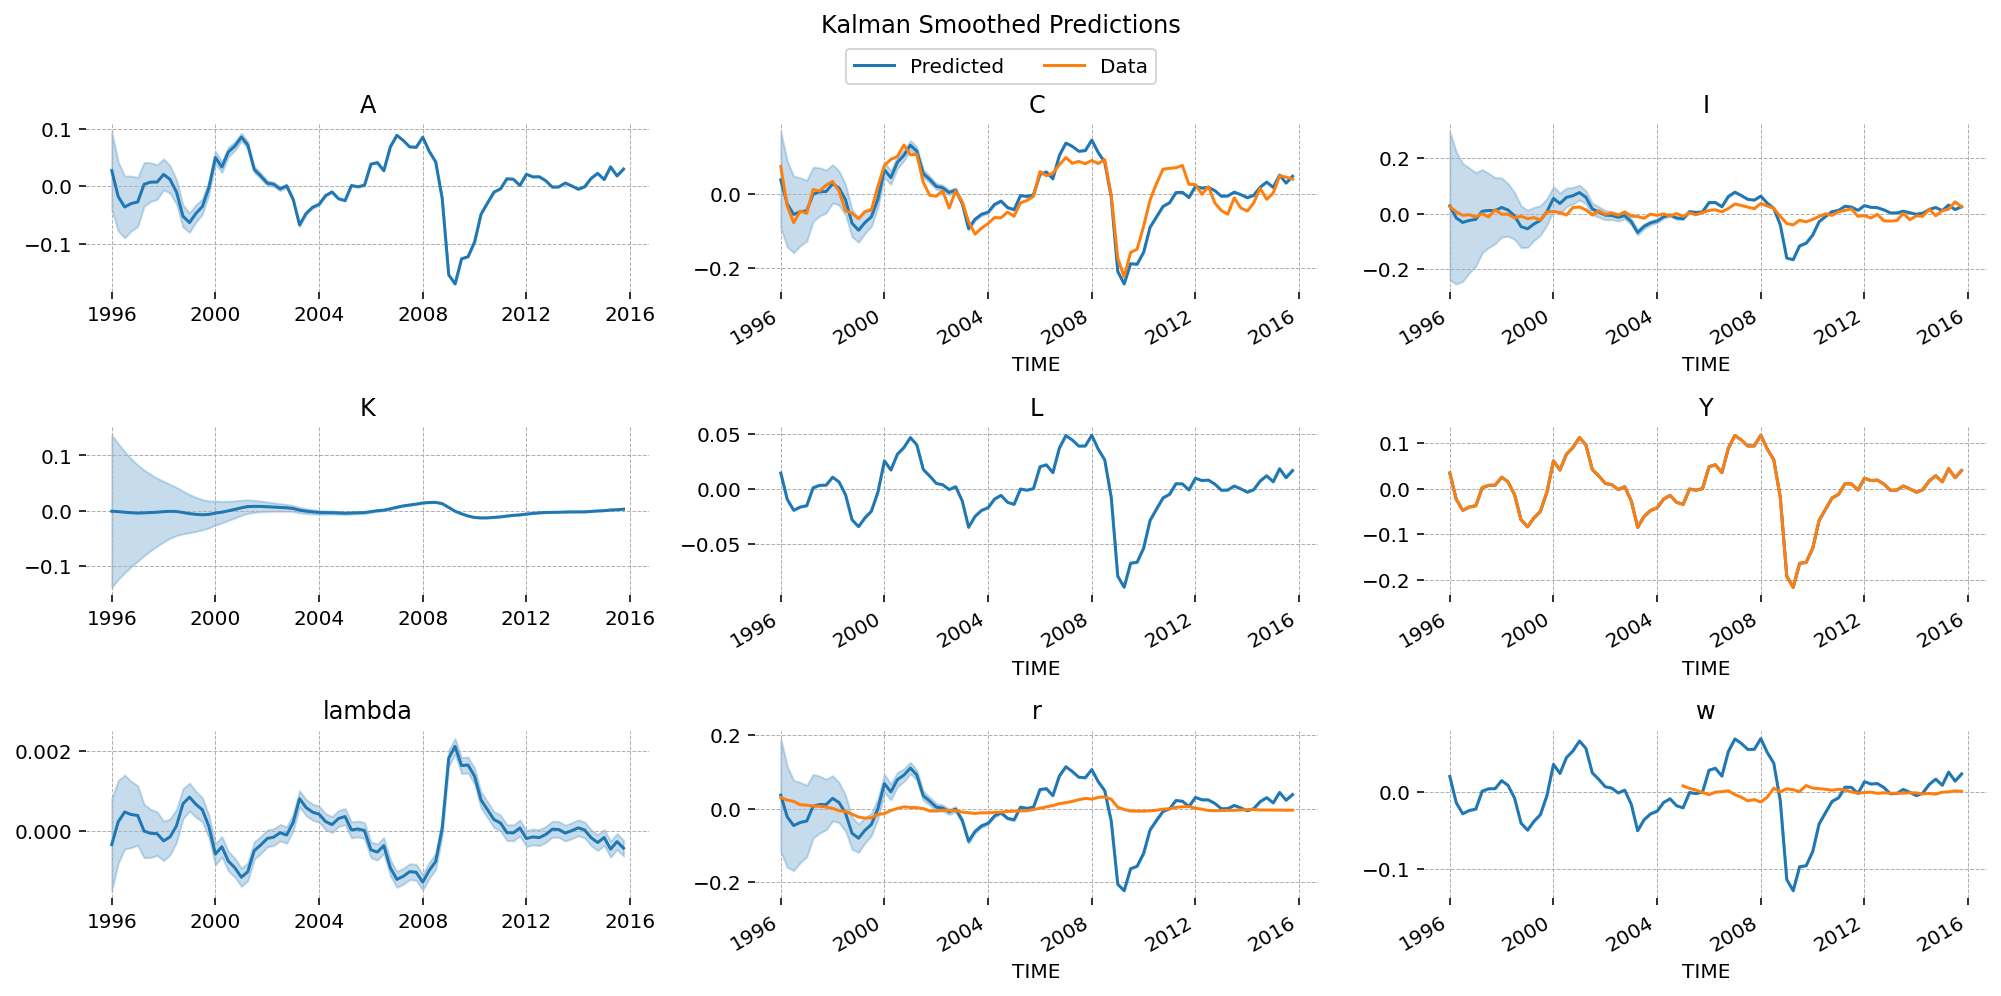

In [24]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_1_2"></a>

In [27]:
mle_forecast = mle_res.get_forecast(steps=test_size)

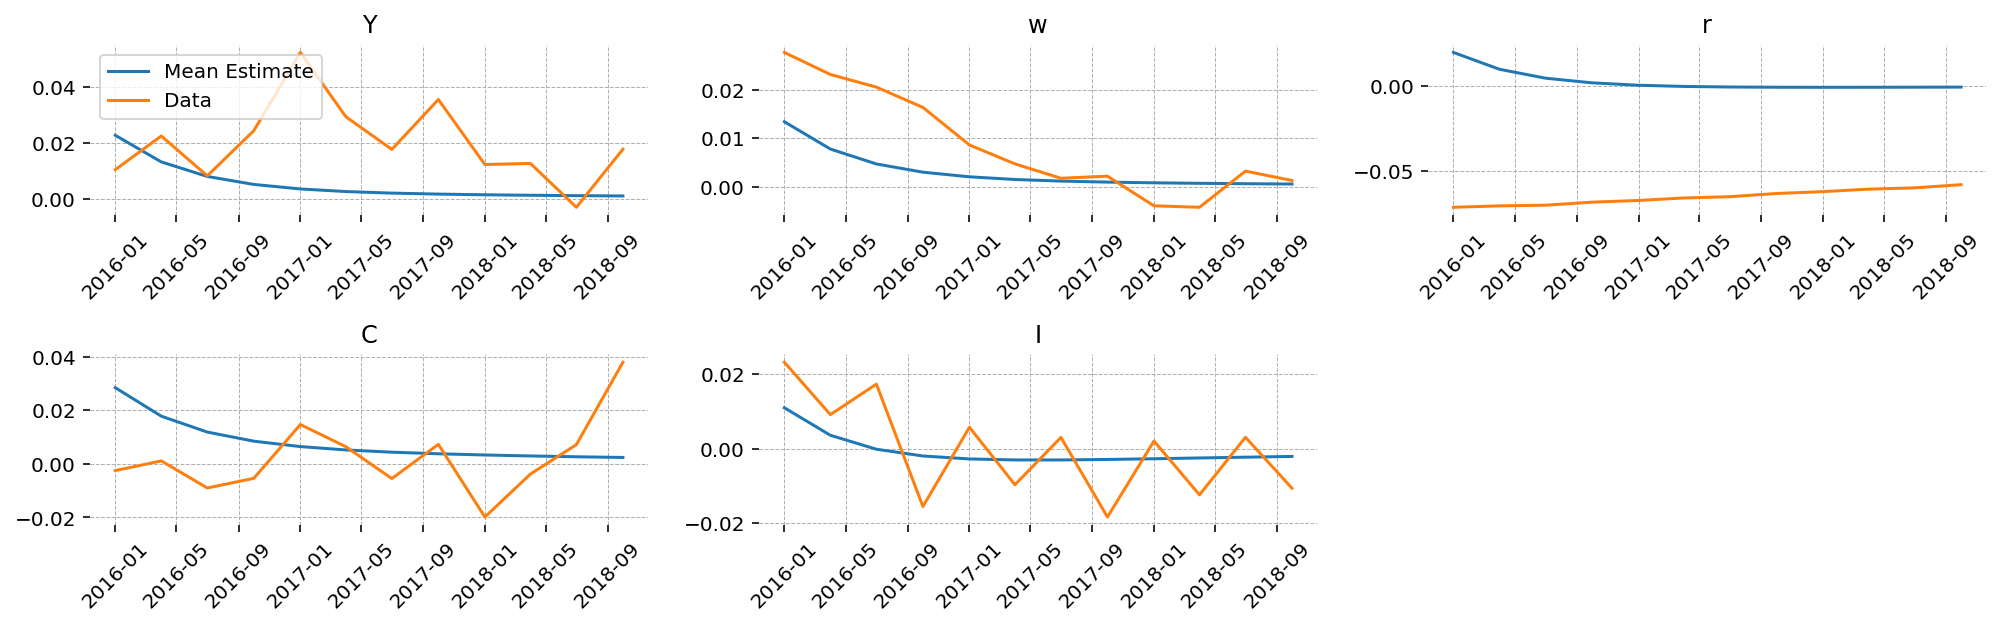

In [28]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'w', 'r', 'C', 'I'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

### Impulse response <a class="anchor" id="subsection_1_3"></a>

In [29]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

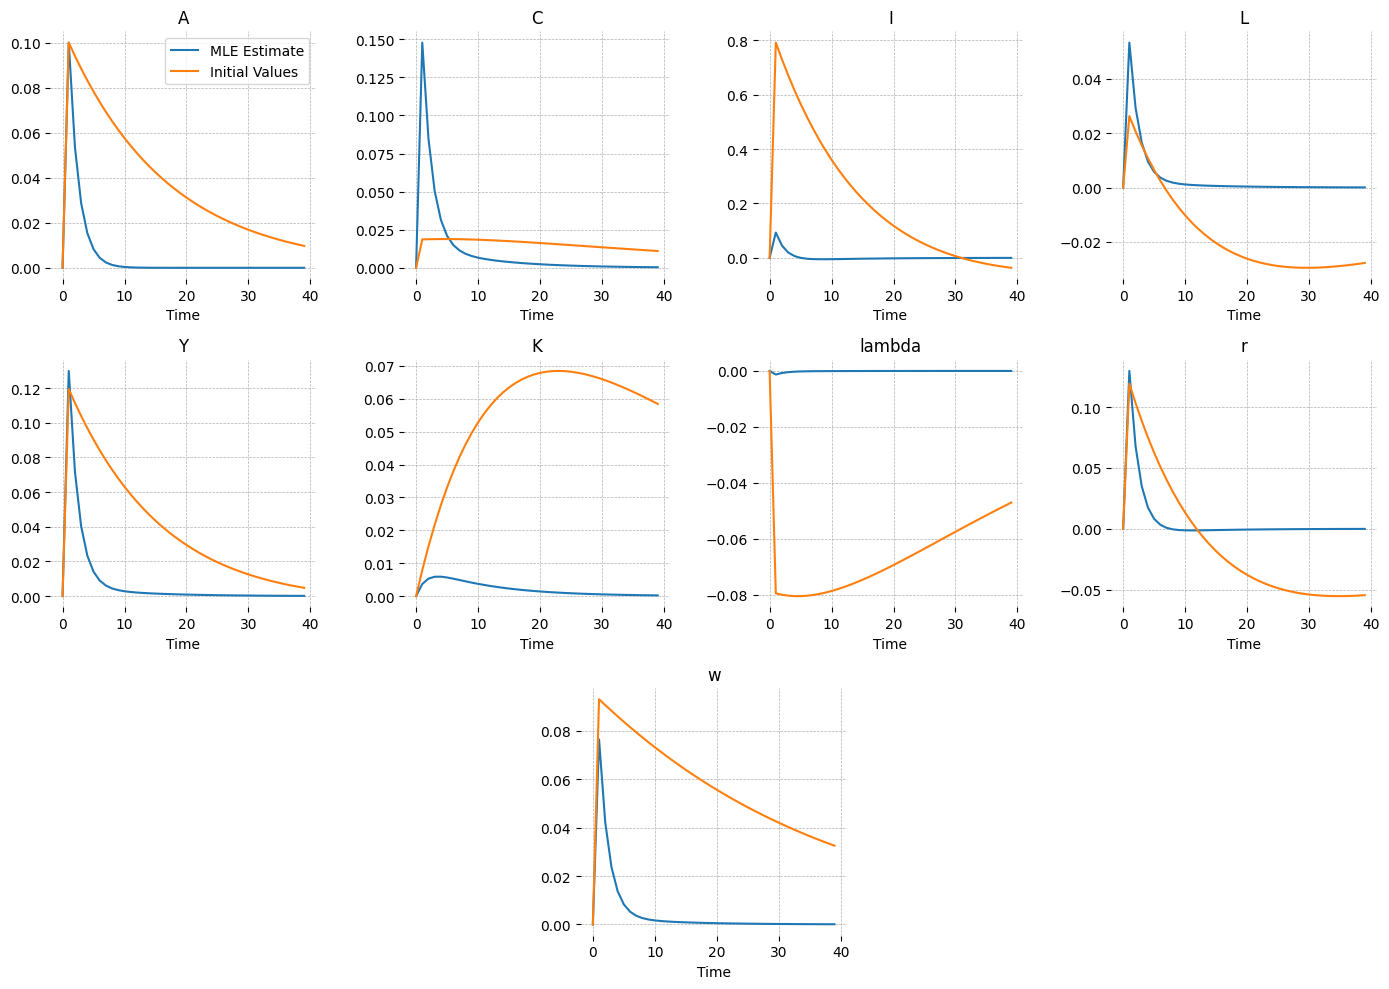

<Figure size 1400x1000 with 0 Axes>

In [30]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

hump shaped capital

consumption thus more spike, as additional income is consumed instead

As we have done before, we analyze a positive shock in productivy of 0.1. 
Starting from the analysis of productivity the shock will be assorbed quicker using MLE estimation, instead with the initial values it takes more time.
Consumption differes first in terms of reaction (more important using MLE estimation), and also in terms of time to reassorbe the shock (quicker using estimation). This is very different compared to what we have seen in the other notebook
The same is true also for investment, where using MLE estimation they become negative after 15 quarters. Related to this the interest rate has a strange dynamics and it follows the same movement as investiment (and if we think about macroeconomic theory we should have that an increase/decrease of the interest rate drives to a decrease/increase of investments) 
Labor reacts much less with respect to the shock and in the end becomes negative in the case of iniatial value.In this cases we can see the Lucas-Rapping effect.
The reaction in GDP is more than the shock in productivity in both cases but then to return to the steady state is quicker for our new estimations.
The dynamics of K is different: using initial values K increase a lot for the first 20 quarters and then start to decrease, instead, using MLE it starts decreasing only after 5 quarters (more reasonable). We can note that the reaction even if different in terms of time, reach more or less the same high.
In the end, wages fit well with the dynamics of labor. The immediate reaction is due to the fact that in our RBC we don't have friction, or sticky prices.

# Bond Model<a class="anchor" id="section_2_1"></a>

In [32]:
rbc = ge.gEconModel(os.path.join(DATA_DIR, 'rbc_bonds.gnc'))

Model Building Complete.
Found:
	12 equations
	12 variables
	The following variables were eliminated at user request:
		U_t
	The following "variables" were defined as constants and have been substituted away:
		B_t,mc_t
	1 stochastic shock
		 1 / 1 have a defined prior. 
	7 parameters
		 2 / 7 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.



## Model Equations <a class="anchor" id="section_2_2"></a>

In [33]:
for equation in rbc.system_equations:
    display(equation)

-C_t + Div_t - I_t + K_t-1*r_t + L_t*w_t

I_t - K_t + K_t-1*(1 - delta)

-lambda_t + C_t**(-sigma_C)

-L_t**sigma_L + lambda_t*w_t

beta*(lambda_t+1*r_t+1 - lambda_t+1*(delta - 1)) - lambda_t

beta*lambda_t+1 - lambda_t/r_G_t

-Div_t + TC_t + Y_t

A_t*K_t-1**alpha*L_t**(1 - alpha) - Y_t

-K_t-1*r_t - L_t*w_t - TC_t

alpha*A_t*K_t-1**(alpha - 1)*L_t**(1 - alpha) - r_t

A_t*K_t-1**alpha*(1 - alpha)/L_t**alpha - w_t

rho_A*log(A_t-1) + epsilon_A_t - log(A_t)

## Find Steady State, Solve the Model <a class="anchor" id="section_2_2"></a>

In [35]:
rbc.steady_state()
rbc.solve_model(not_loglin_variable=['Div', 'TC'])

Steady state found! Sum of squared residuals is 1.830403819145629e-30
Solution found, sum of squared residuals:  1.1253491572151774e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


In [36]:
rbc.print_steady_state()

A_ss               1.000
C_ss               2.358
Div_ss             0.000
I_ss               0.715
K_ss              35.732
L_ss               0.820
TC_ss             -3.073
Y_ss               3.073
lambda_ss          0.276
r_G_ss             1.010
r_ss               0.030
w_ss               2.436


## Check Blanchard Kahn Conditions <a class="anchor" id="section_2_3"></a>

As we know from theory the Blanchard condition are important because they let us understand if the model has a unique solution through the steady state.

In [37]:
rbc.check_bk_condition()

Model solution has 2 eigenvalues greater than one in modulus and 2 forward-looking variables.
Blanchard-Kahn condition is satisfied.


,Modulus,Real,Imaginary
0,4.006795e-35,4.006795e-35,0.0
1,1.652291e-18,-1.652291e-18,-0.0
2,9.434787e-17,9.434787e-17,0.0
3,9.500000e-01,9.500000e-01,0.0
4,9.697454e-01,9.697454e-01,0.0
5,1.041615e+00,1.041615e+00,0.0
6,5.077961e+06,5.077961e+06,0.0


In [38]:
#Run IRFs with our starting parameters to compare with the estimated parameters at the end.
base_irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

As we can see the output the number of unstable variables is the same as the number of control variable as a consequence the system has a unique solution.

# Maximum Likelihood Estimation <a class="anchor" id="chapter3"></a>

In [39]:
# assign date freq
train = train.asfreq("QS")
train.head()

,Y,I,r,C,w,L
TIME,,,,,,
1996-01-01,0.034739,0.025376,0.030090,0.073761,NaN,0.006896
1996-04-01,-0.023203,0.006568,0.023159,-0.032295,NaN,NaN
1996-07-01,-0.047401,-0.006060,0.019601,-0.077407,NaN,NaN
1996-10-01,-0.040238,-0.003936,0.010456,-0.046165,NaN,NaN
1997-01-01,-0.037205,-0.012070,0.009416,-0.052189,NaN,-0.005354


In [40]:
MLEModel = ge.compile_to_statsmodels(rbc)
rbc.free_param_dict.update(calibrated_params)

In [41]:
# Try estimating everything, why not?
param_start_dict = {'rho_A':0.85,
                    'sigma_C':0.1,
                    'sigma_L':0.3,
                    'alpha':0.35,
                    'beta':0.98,
                    'delta':0.035}

shock_start_dict = {'epsilon_A':0.5}

# We have to add noise to everything but Y, or else we'll get the stochastic singularity
noise_start_dict = {'L':0.01,
                    'w':0.01,
                    'r':0.01,
                    'C':0.01,
                    'I':0.01}

param_transforms = {'rho_A':IntervalTransformer(low=0.01, high=0.99),
                    'sigma_C':IntervalTransformer(low=0.001, high=5.0),
                    'sigma_L':IntervalTransformer(low=0.001, high=5.0),
                    'alpha':IntervalTransformer(low=0.1, high=0.5),
                    'beta':IntervalTransformer(low=0.9, high=0.999),
                    'delta':IntervalTransformer(low=0.01, high=0.05)}

# Build the model!
mle_mod = MLEModel(train[['Y', 'L', 'w', 'r', 'C', 'I']],
               param_start_dict = param_start_dict,
               shock_start_dict = shock_start_dict,
               noise_start_dict = noise_start_dict,
               param_transforms = param_transforms,
               shock_transforms=None, # If None, will automatically transform to positive values only
               noise_transforms=None, # If None, will automatically transform to positive values only
               initialization='stationary')

In [42]:
# %%capture
# basinhopping as algorithm, mixes different approaches 
mle_res = mle_mod.fit(method='basinhopping', minimizer={'method':'L-BFGS-B'}, maxiter=maxiter)

basinhopping step 0: f 80.9597
basinhopping step 1: f 1.61693 trial_f 1.61693 accepted 1  lowest_f 1.61693
found new global minimum on step 1 with function value 1.61693
basinhopping step 2: f 1.3457 trial_f 1.3457 accepted 1  lowest_f 1.3457
found new global minimum on step 2 with function value 1.3457
basinhopping step 3: f 0.139629 trial_f 0.139629 accepted 1  lowest_f 0.139629
found new global minimum on step 3 with function value 0.139629
basinhopping step 4: f -0.665887 trial_f -0.665887 accepted 1  lowest_f -0.665887
found new global minimum on step 4 with function value -0.665887
basinhopping step 5: f -1.0367 trial_f -1.0367 accepted 1  lowest_f -1.0367
found new global minimum on step 5 with function value -1.0367
basinhopping step 6: f -3.27616 trial_f -3.27616 accepted 1  lowest_f -3.27616
found new global minimum on step 6 with function value -3.27616
basinhopping step 7: f -2.54378 trial_f -2.54378 accepted 1  lowest_f -3.27616
basinhopping step 8: f -2.54378 trial_f 0.88

In [43]:
mle_res.summary()

C:\Users\LukasGrahl\Documents\GIT\macro_rbc\env_macro_rbc\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:     ['Y', 'L', 'w', 'r', 'C', 'I']   No. Observations:                   80
Model:                                  DSGEModel   Log Likelihood                  95.139
Date:                            Sat, 10 Dec 2022   AIC                           -166.277
Time:                                    11:14:29   BIC                           -137.693
Sample:                                01-01-1996   HQIC                          -154.817
                                     - 10-01-2015                                         
Covariance Type:                              opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rho_A                0.7675     11.396      0.067      0.946     -21.568      23.103
sigma_C              0.0912     12.955      0.007      0.994     -25.300      25.482
sigma_L              0.8198     19.919      0.041      0.967     -38.220      39.859
alpha                0.2887     43.781      0.007      0.995     -85.521      86.099
beta                 0.9942      5.242      0.190      0.850      -9.280      11.269
delta                0.0302      0.454      0.067      0.947      -0.860       0.920
sigma2.epsilon_A     0.0583      5.275      0.011      0.991     -10.280      10.397
sigma2.L             0.0820      0.050      1.653      0.098      -0.015       0.179
sigma2.w             0.0856      0.046      1.852      0.064      -0.005       0.176
sigma2.r             0.0166      0.286      0.058      0.954      -0.543       0.576
sigma2.C             0.0324      0.212      0.153      0.878      -0.383       0.448
sigma2.I             0.7738     25.892      0.030      0.976     -49.974      51.522
=================================================================================================================================
Ljung-Box (L1) (Q):     14.20, 0.00, 65.06, 68.40, 58.36, 58.16   Jarque-Bera (JB):   360.35, 506.52, 58.26, 13.09, 16.26, 103.08
Prob(Q):                     0.00, 1.00, 0.00, 0.00, 0.00, 0.00   Prob(JB):                    0.00, 0.00, 0.00, 0.00, 0.00, 0.00
Heteroskedasticity (H):       0.47, 0.60, inf, 0.10, 1.81, 1.81   Skew:                      -2.09, 1.58, 1.01, 0.92, -0.70, 1.67
Prob(H) (two-sided):         0.06, 0.18, 0.00, 0.00, 0.13, 0.13   Kurtosis:                  12.52, 14.92, 6.66, 3.75, 4.72, 7.45
=================================================================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (centered finite differences).
"""

### MLE Kalman Filter Prediction Plots <a class="anchor" id="subsection_3_1"></a>

This model shows interesting dynamics for consumption. Even though time lagged, the predictions do somehow seem to follow the consumption pattern of the italian economy. This happens because using a complete model with the bonds market can take into account both the dynamics of wealth and also the dynamics of a (even if restriced) financial market. In this sense we can have better approximation. It could be interesting to note instead that our model don't follow the dynamycs of the interest rate in any sense.

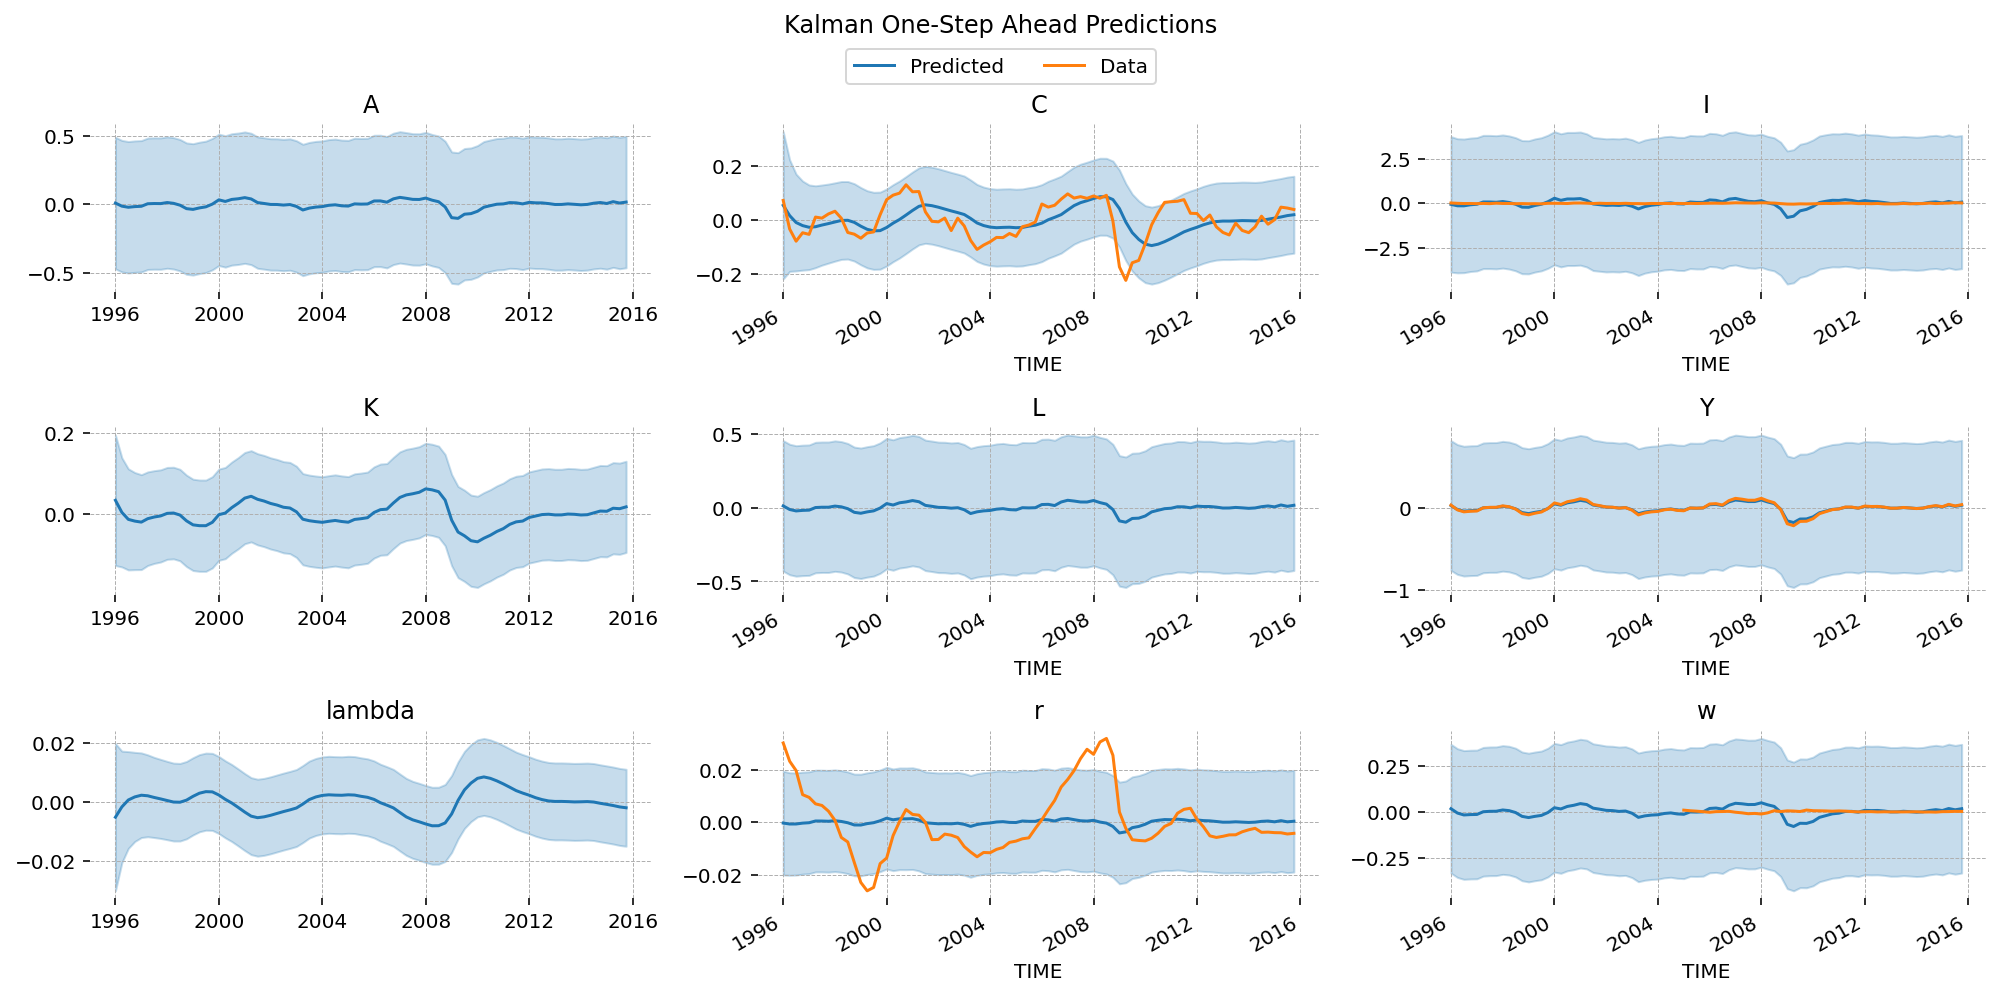

In [51]:
plot_sm_results(mle_res, train, var_names=plot_vars)

Smoothed output

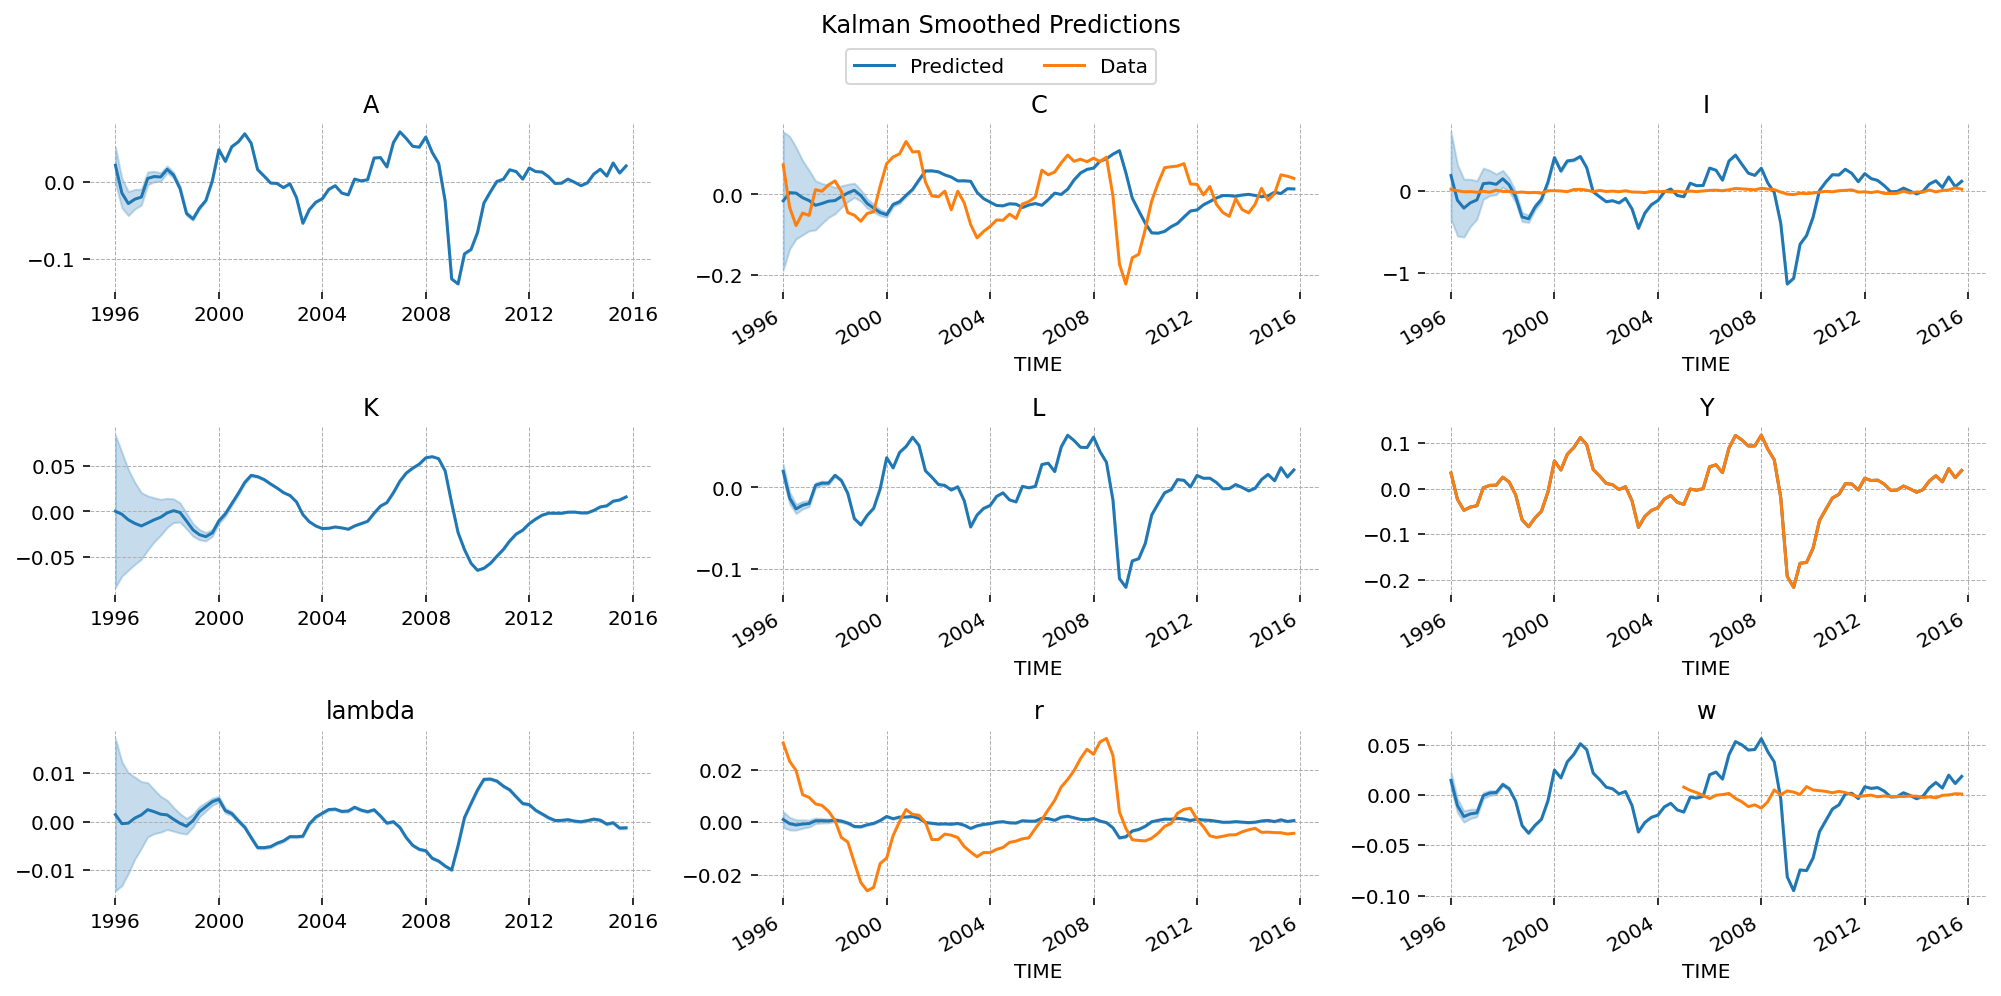

In [52]:
plot_sm_results(mle_res, train, 'smoothed', var_names=plot_vars)

### Forecasting <a class="anchor" id="subsection_3_2"></a>

In [53]:
mle_forecast = mle_res.get_forecast(steps=test_size)

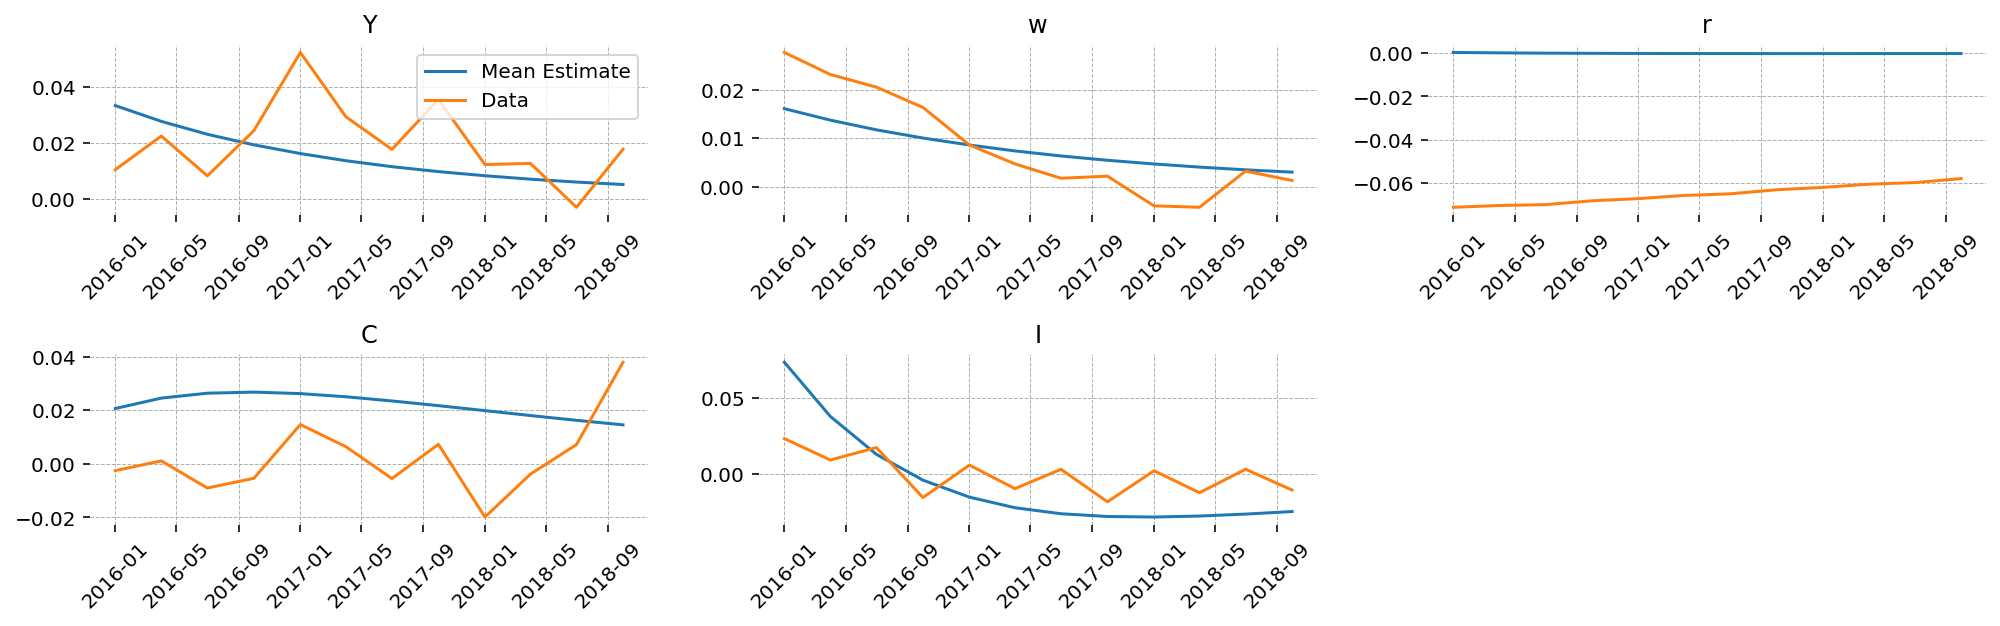

In [54]:
everything_forecast = mle_res.get_forecast(steps=test_size)
mu = everything_forecast.predicted_mean

n_quarters = 12
gs, locs = gp.prepare_gridspec_figure(n_cols=3, n_plots=6)

fig = plt.figure(figsize=(14, 6))
for var, loc in zip(['Y', 'w', 'r', 'C', 'I'], locs):
    axis = fig.add_subplot(gs[loc])
    axis.plot(mu[var].iloc[:n_quarters], label='Mean Estimate')
    axis.plot(test[var].iloc[:n_quarters], label='Data')
    axis.tick_params(axis='x', rotation=45)
    axis.set_title(var)

fig.axes[0].legend()
fig.tight_layout()
plt.show()

As before, also in this case the interest rate has no correct prediction. 

### Impulse response <a class="anchor" id="subsection_3_3"></a>

In [56]:
irf = rbc.impulse_response_function(simulation_length=40, shock_size=0.1)

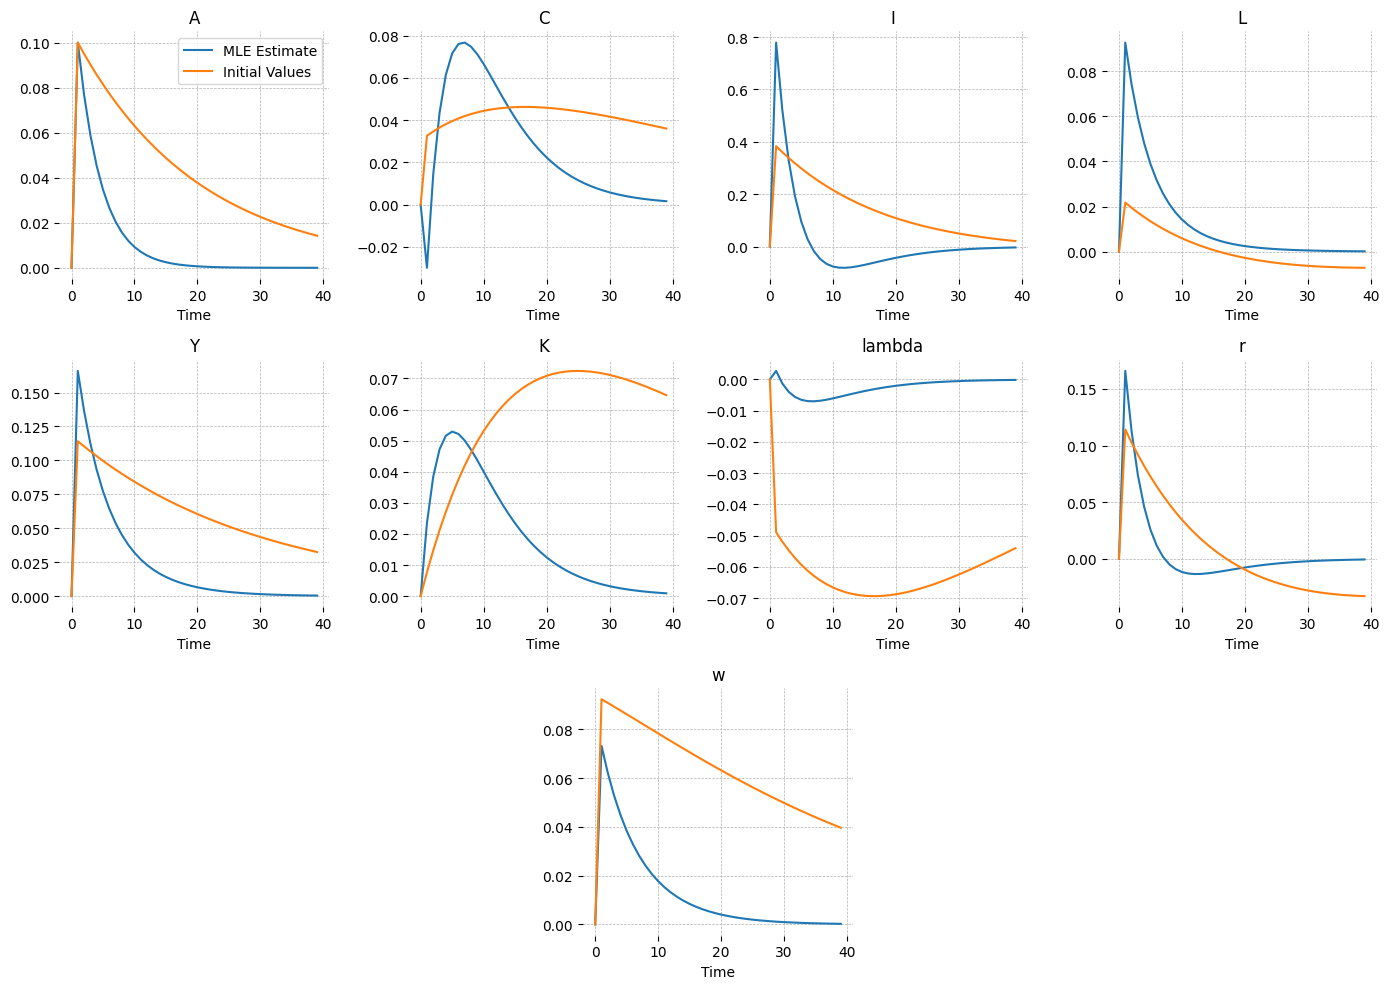

<Figure size 1400x1000 with 0 Axes>

In [57]:
fig = gp.plot_irf(irf.rename(columns={'epsilon_A':'MLE Estimate'}), vars_to_plot=plot_vars)
fig2 = gp.plot_irf(base_irf, vars_to_plot=plot_vars)

for axis, axis2 in zip(fig.axes, fig2.axes):
    line = axis2.get_children()[0]
    axis.plot(line.get_data()[0], line.get_data()[1], color='tab:orange', label='Initial Values')

    
fig.axes[0].legend()
fig2.clear()
fig2.set_visible(False)
plt.show()

To be consistent, we analyze a positive shock in productivy of 0.1 as in the other cases.
We can note that for productivity, investment, labor, GDP, capital, interest rate and wages the dynamics is the same as before.
The interessant difference is in the dynamics of consumption with our estimation. In particular, we observer that after the shock, we decrease consumption for at least one year and then it restart follow the same dynamics as in the case of capital adjustment costs. It is difficlut to understand why this can happen.